# Render a textured mesh

This tutorial shows how to:

1) Load **mesh** and **textures** from an `.obj` and `.mtl` files

2) Setup a renderer

3) Render the mesh

4) Vary the rendering settings, such as lightning and camera position

5) Use the batching features of the PyTorch3D API to render the mesh from different viewpoints

This tutorial is based on the [official documentation](https://pytorch3d.org/tutorials/render_textured_meshes) with some slight ammendments.

In [1]:
import os
import torch
import matplotlib.pyplot as plt
from skimage.io import imread

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, load_obj

# Data structures and functions for rendering
from pytorch3d.structures import Meshes
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
    TexturesUV,
    TexturesVertex
)

# add path for demo utils functions 
import sys
import os
sys.path.append(os.path.abspath(''))

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



In [2]:
from plot_image_grid import image_grid

### 1) Load **mesh** and **textures** from an `.obj` and `.mtl` files

In this part we load an `.obj` file and its associated `.mtl` file. If you want to know more details on how to parse an `obj` file, see this reference [1](https://www.fileformat.info/format/wavefrontobj/egff.htm).

In Pytorch3D, loading `.obj` file creates **Meshes** and **Textures** object. **Meshes** is a unique datastructure in PyTorch3D for working with batches of meshes of different sizes. **TexturesUV** is an auxiliary datastructure for storing vertex UV and texture maps for meshes. 

**Meshes** has several class methods, which are used throughout the rendering pipeline. 

In this tutorial, we'll work with 2 different `.obj` files:

1) `capsule.obj` stored in `./data/capsule`

2) `cow.obj` stored in `./data/cow_mesh`

Let's load the `.obj` file:

In [166]:
# Set the device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")
print(device)  

# Set paths
DATA_DIR = "./data"
obj_filename = os.path.join(DATA_DIR, "capsule/capsule.obj")

# Load the .obj file
mesh = load_objs_as_meshes([obj_filename], load_textures = True, device=device)

cpu


This creates new `Meshes` object, `mesh`.  `mesh` has attributes such as `verts_packed`, `faces_packed`, and others. For the full list of attributes, please see the [official documentation](https://pytorch3d.readthedocs.io/en/latest/_modules/pytorch3d/structures/meshes.html).

We can get some basic information about the object:

In [167]:
# Number of vertices:
print("The number of packed vertices in the Meshes object: " + str(mesh.verts_packed().shape[0]))
# Number of faces:
# Number of vertices:
print("The number of packed faces in the Meshes object: " + str(mesh.faces_packed().shape[0]))

The number of packed vertices in the Meshes object: 5252
The number of packed faces in the Meshes object: 10200


You can also load the `.obj` file by calling the following. For more information, see [Meshes and IO](https://pytorch3d.org/docs/meshes_io).


In [168]:
verts, faces, aux = load_obj(obj_filename)
print(verts.shape)
print(faces.verts_idx.shape)

torch.Size([5252, 3])
torch.Size([10200, 3])


Here `verts` is a (V,3)- tensor of vertices and `faces.verts_idx` is an (F,3)- tensor of the vertex-indices of each of the corners of the faces. Faces, which are not triangles, will be split into triangles.


We can visualize the texture associated with the `.obj` file:

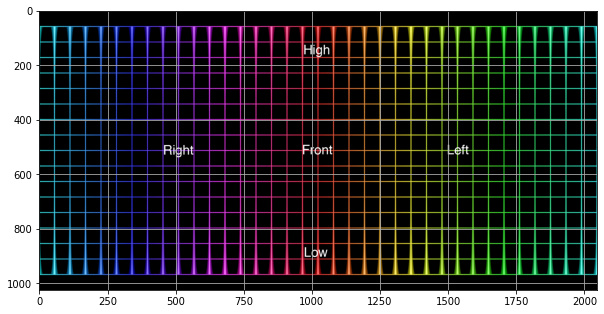

In [169]:
# Get the texture tensor and convert it to the numpy array:
texture_image = mesh.textures.maps_padded()
texture_image_numpy = texture_image.squeeze().cpu().numpy()

plt.figure(figsize=(10, 10))
plt.imshow(texture_image_numpy)
plt.grid("off")

PyTorch3D has a built-in way to view the texture map with `matplotlib` along with the points on the map corresponding to vertices. There is also a method, `texturesuv_image_PIL`, to get a similar image which can be saved to a file.


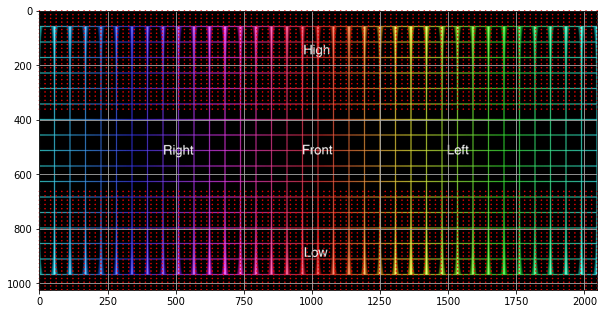

In [170]:
plt.figure(figsize=(10, 10))
texturesuv_image_matplotlib(mesh.textures, subsample=None)
plt.grid("off")


### 2) Create a renderer

**A renderer in PyTorch3D is composed of a rasterizer and a shader.** Both rasterizer and shader have a number of subcomponents, such as camera. Here we initialize some of the components and use default values for the rest.

In this example, we will first create a **renderer** which uses:
- a perspective camera, 
- point light, and 
- phong shading

Then we learn how to vary different components using the modular API.


**Camera setting:** Let's initialize the camera. The world coordinates are as follows: +Y is up, +X is left, and +Z is into the page. So the front of the capsule is facing -Z direction. We move the camera by 180 degrees in the azimuth direction so that it is facing the front of the capsule.

To set up the rotation and translation matrices, we use `look_at_view_transform()` method, which has the following arguments:


- `dist`: distance of the camera from the object
- `elev`: angle in degres or radians. This is the angle between the vector from the object to the camera, and the horizontal plane y = 0 (xz-plane).
- `azim`: angle in degrees or radians. The vector from the object to the camera is projected onto a horizontal plane y = 0. azim is the angle between the projected vector and a reference vector at (1, 0, 0) on the reference plane (the horizontal plane).

Read the docs here: https://pytorch3d.readthedocs.io/en/latest/modules/renderer/cameras.html

In [171]:
R, T = look_at_view_transform(dist = 3, elev = 90, azim = 0) 
cameras = FoVPerspectiveCameras(device = device, R = R, T = T)

print(R)
print(T)

tensor([[[ 1.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  4.3711e-08, -1.0000e+00],
         [-0.0000e+00,  1.0000e+00,  4.3711e-08]]])
tensor([[-0., -0., 3.]])


In [172]:
# Define the settings for rasterization and shading. We set the output image size to 128x128, 256x256, etc.
# As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# and blur_radius=0.0. We also set bin_size and max_faces_per_bin to None which ensure that 
# the faster coarse-to-fine rasterization method is used. Refer to rasterize_meshes.py for 
# explanations of these parameters. Refer to docs/notes/renderer.md for an explanation of 
# the difference between naive and coarse-to-fine rasterization. 

raster_settings = RasterizationSettings(
    image_size = 256, 
    blur_radius = 0.0, 
    faces_per_pixel = 1, 
)

# Place a point light in front of the object. As mentioned above, the front of the cow is facing the 
# -z direction. 
lights = PointLights(device=device, location=[[0.0, 0.0, -3.3]])



# Create a phong renderer by composing a rasterizer and a shader. The textured phong shader will 
# interpolate the texture uv coordinates for each vertex, sample from a texture image and 
# apply the Phong lighting model

renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=SoftPhongShader(
        device=device, 
        cameras=cameras,
        lights=lights
    )
)

### 3) Render the mesh

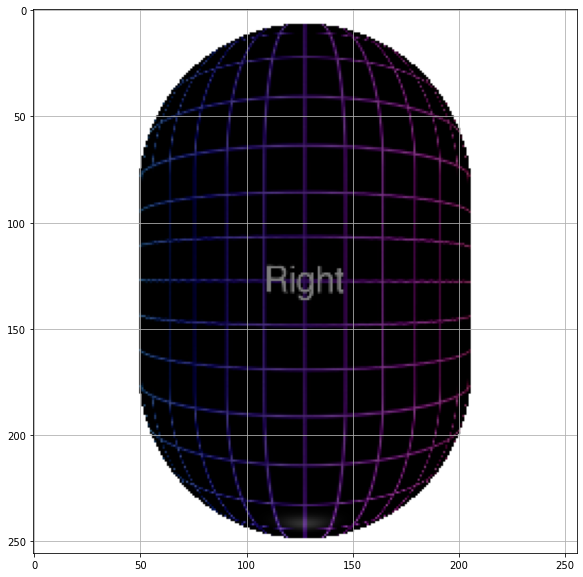

In [173]:
images = renderer(mesh)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off")

### 4. Move the light behind the object and re-render

We can pass arbirary keyword arguments to the `rasterizer/shader` via the call to the `renderer` so the renderer does not need to be reinitialized if any of the settings change/

In this case, we can update the location of the lights and pass them into the call to the `renderer`.

The image is now dark as there is only ambient lighting, and there are no specular highlights.




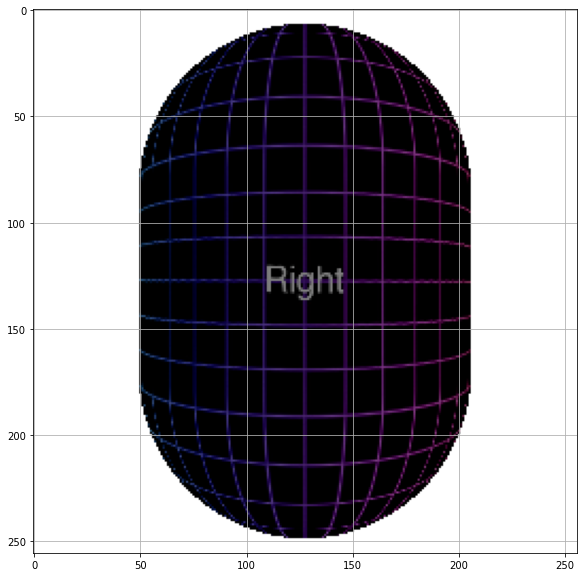

In [174]:
# Move the light so it is on the +Z axis which will be behind the capsule object

lights.location = torch.tensor([0.0, 0.0, +1.0], device=device)[None]
images = renderer(mesh, lights=lights)


plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off")

### 5. Rotate the object, modify the material properties or light properties

We can change other settings in the rendering pipeline, such as:

- viewing angle of the camera
- position of the point light
- material reflectance properties of the mesh

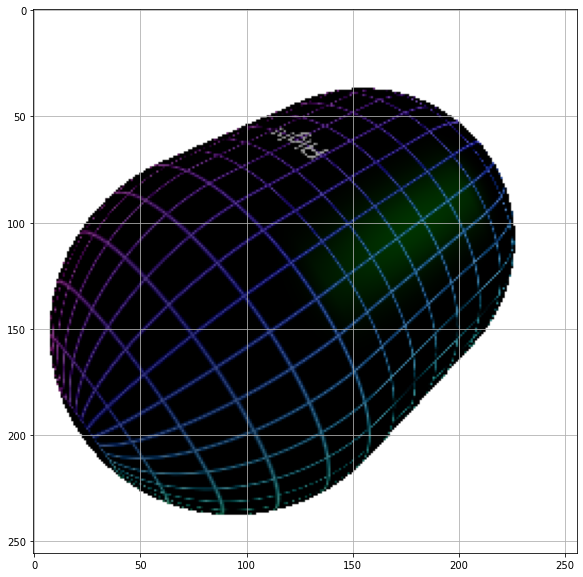

In [175]:
# Rotate the object by increasing the elevation and azimuth angles

R, T = look_at_view_transform(dist = 3, elev = 45, azim = 45) 
cameras = FoVPerspectiveCameras(device = device, R = R, T = T)



# Move the light location so the light is located in front of the object
lights.location = torch.tensor([[2.0, 2.0, -2.0]], device=device)

# Change specular color to green and change material shininess 
materials = Materials(
    device=device,
    specular_color=[[0.0, 1.0, 0.0]],
    shininess=10.0
)

# Re render the mesh, passing in keyword arguments for the modified components.
images = renderer(mesh, lights = lights, materials = materials, cameras = cameras)

plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off")

### 6. Batched Rendering

One of the core design choices of the PyTorch3D API is to support batched inputs for all components. The renderer and associated components can take batched inputs and render a batch of output images in one forward pass. We will now use this feature to render the mesh from many different viewpoints.

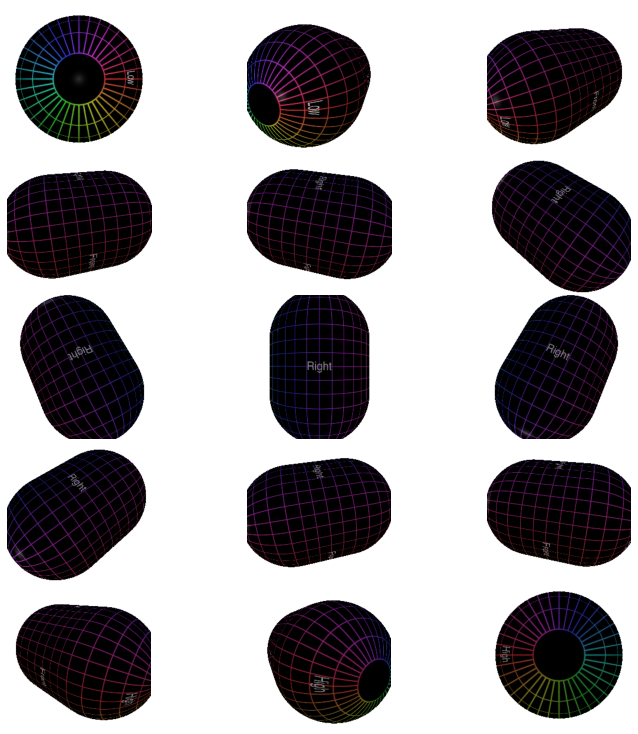

In [176]:
# Set batch size, which corresponds to the number of different viewpoints from which we want to render the mesh
batch_size = 15

# Create a batch of meshes by repeating the capsule mesh and associated textures. 
# Meshes has a useful `extend` method which allows us do this very easily. 
# This also extends the textures. 
meshes = mesh.extend(batch_size)

# Get a batch of viewing angles. 
elev_vec = torch.linspace(0, 180, batch_size)
azim_vec = torch.linspace(-180, 180, batch_size)

# All the cameras helper methods support mixed type inputs and broadcasting. So we can 
# view the camera from the same distance and specify dist=2.7 as a float,
# and then specify elevation and azimuth angles for each viewpoint as tensors. 
R, T = look_at_view_transform(dist = 2.7, elev = elev_vec, azim = azim_vec)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

# Move the light back in front of the cow which is facing the -z direction.
lights.location = torch.tensor([[0.0, 0.0, -3.0]], device=device)


# We can pass arbirary keyword arguments to the rasterizer/shader via the renderer
# so the renderer does not need to be reinitialized if any of the settings change.
images = renderer(meshes, cameras = cameras, lights = lights)


image_grid(images.cpu().numpy(), figsize=(10,10), rows=5, cols=3, rgb=True)

In [179]:
print(images.shape)

torch.Size([15, 256, 256, 4])


**What if we have one .mtl file but multiple texture files?**


In [180]:
# Set paths
DATA_DIR = "./data"
obj_filename = os.path.join(DATA_DIR, "person/adam-v1.obj")

# Load the .obj file
mesh = load_objs_as_meshes([obj_filename], load_textures = True, device=device)

In [181]:
# Number of vertices:
print("The number of packed vertices in the Meshes object: " + str(mesh.verts_packed().shape[0]))
# Number of faces:
# Number of vertices:
print("The number of packed faces in the Meshes object: " + str(mesh.faces_packed().shape[0]))


The number of packed vertices in the Meshes object: 32690
The number of packed faces in the Meshes object: 64650


In [182]:
# Get the texture tensor and convert it to the numpy array:
texture_image = mesh.textures.maps_padded()
texture_image_numpy = texture_image.squeeze().cpu().numpy()

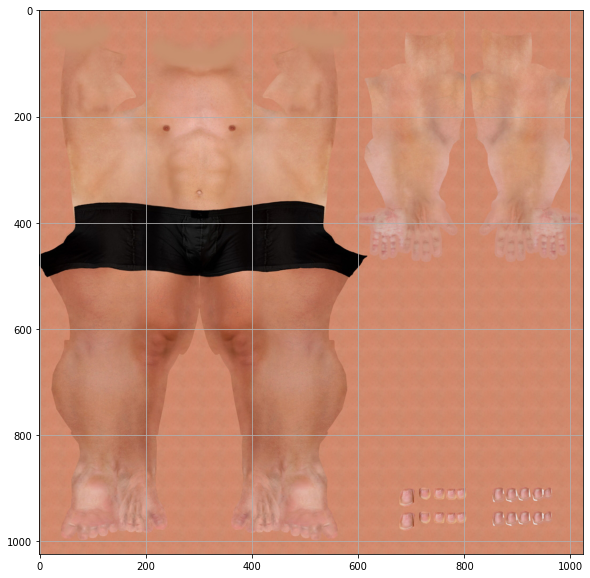

In [183]:
plt.figure(figsize=(10, 10))
plt.imshow(texture_image_numpy)
plt.grid("off")

In [184]:
R, T = look_at_view_transform(dist = 3, elev = 0, azim = 0) 
cameras = FoVPerspectiveCameras(device = device, R = R, T = T)


raster_settings = RasterizationSettings(
    image_size = 256, 
    blur_radius = 0.0, 
    faces_per_pixel = 1, 
)


lights = PointLights(device=device, location=[[0.0, 0.0, -3.3]])

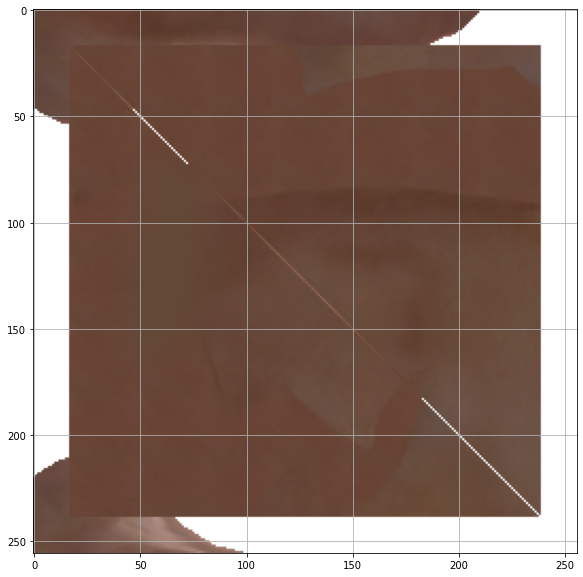

In [185]:
images = renderer(mesh, cameras = cameras)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off")

### References
[1](https://www.fileformat.info/format/wavefrontobj/egff.htm) How to parse an `.obj` file